In [1]:
import matplotlib.pyplot as plt
import numpy as np
import keyboard as kb
from IPython.display import clear_output

In [2]:
class pawn:
    def __init__(self, x=0, y=0):
        self.x, self.y=x, y
    def __repr__(self):
        return "["+str(self.x)+", "+str(self.y)+"]"
    def move(self, direction):
        if direction=="left":
            if self.x > 0:
                self.x-=1
        elif direction=="right":
            if self.x < 8:
                self.x+=1
        elif direction=="up":
            if self.y > 0:
                self.y-=1
        elif direction=="down":
            if self.y < 8:
                self.y+=1
        elif direction=="doubleleft":
            if self.x > 1:
                self.x-=2
        elif direction=="doubleright":
            if self.x < 7:
                self.x+=2
        elif direction=="doubleup":
            if self.y > 1:
                self.y-=2
        elif direction=="doubledown":
            if self.y < 7:
                self.y+=2
    def future_move(self, direction):
        x, y=self.x, self.y
        fx, fy=x, y
        if direction=="left": fx-=1
        elif direction=="right": fx+=1
        elif direction=="up": fy-=1
        elif direction=="down": fy+=1
        elif direction=="doubleleft": fx-=2
        elif direction=="doubleright": fx+=2
        elif direction=="doubleup": fy-=2
        elif direction=="doubledown": fy+2

        return [[x, y], [fx, fy]]

    def coord(self):
        return [self.x, self.y]
    
    def near_coord(self):
        x, y=self.x, self.y
        return [[x-1, y], [x, y-1], [x+1, y], [x, y+1]]

In [3]:
class wall:
    def __init__(self, x=0, y=0, direction="left"):
        self.x, self.y, self.direction=x, y, direction
    def __repr__(self):
        return "["+str(self.x)+", "+str(self.y)+", " + self.direction + "]"

In [4]:
class pawnController:
    def __init__(self):
        self.pawnList={}
    def add_pawn(self, name, pawn):
        if name not in self.pawnList:
            if 0 <= pawn.x <= 8 and 0 <= pawn.y <= 8: 
                self.pawnList[name]=pawn

    def matrix(self):
        matrix=[[0 for _ in range(9)] for _ in range(9)]
        for i in self.pawnList:
            pawn=self.pawnList[i]
            matrix[pawn.y][pawn.x]=1
        return matrix

    def move_pawn(self, name, direction):
        self.pawnList[name].move(direction)

    def detect_near(self, name):
        near_pos=self.pawnList[name].near_coord()
        for i in self.pawnList:
            pawn=self.pawnList[i]
            coord=pawn.coord()
            if coord==near_pos[0]:      return "left"
            elif coord==near_pos[1]:    return "up"
            elif coord==near_pos[2]:    return "right"
            elif coord==near_pos[3]:    return "down"
        return 0

In [5]:
class wallController:
    def __init__(self):
        self.wallList={}
    def add_wall(self, name, wall):
        if name not in self.wallList:
            if wall.direction == "left" and 2 <= wall.x <= 9 and 1 <= wall.y <= 8:
                self.wallList[name]=wall
            elif wall.direction == "up" and 1 <= wall.x <= 8 and 2 <= wall.y <= 9:
                self.wallList[name]=wall
    def matrix(self):
        matrix=[[0 for _ in range(10)] for _ in range(10)]
        for i in self.wallList:
            wall=self.wallList[i]
            if wall.direction == "left":
                matrix[wall.y][wall.x-1]+=2
                matrix[wall.y][wall.x]+=2
            elif wall.direction == "up":
                matrix[wall.y][wall.x]+=3
                matrix[wall.y-1][wall.x]+=3
        return matrix

    def ill_moves(self):
        illegal_moves=[]
        for i in self.wallList:
            wall=self.wallList[i]
            x=wall.x
            y=wall.y
            if wall.direction=="left":
                illegal_moves.extend([[[x-1, y], [x-1, y-1]],
                                        [[x-1, y-1], [x-1, y]],
                                        [[x-2, y], [x-2, y-1]],
                                        [[x-2, y-1], [x-2, y]],
                                        [[x-2, y-2], [x-2, y]],
                                        [[x-1, y-2], [x-1, y]],
                                        [[x-2, y+1], [x-2, y-1]],
                                        [[x-1, y+1], [x-1, y-1]],
                                        [[x-2, y-1], [x-1, y]],
                                        [[x-1, y], [x-2, y-1]],
                                        [[x-2, y], [x-1, y-1]],
                                        [[x-1, y-1], [x-2, y]]])
            elif wall.direction=="up":
                illegal_moves.extend([[[x, y-2], [x-1, y-2]],
                                        [[x-1, y-2], [x, y-2]],
                                        [[x, y-1], [x-1, y-1]],
                                        [[x-1, y-1], [x, y-1]],
                                        [[x-2, y-2], [x, y-2]],
                                        [[x-2, y-1], [x, y-1]],
                                        [[x+1, y-2], [x-1, y-2]],
                                        [[x+1, y-1], [x-1, y-1]],
                                        [[x-1, y-2], [x, y-1]],
                                        [[x, y-1], [x-1, y-2]],
                                        [[x-1, y-1], [x, y-2]],
                                        [[x, y-2], [x-1, y-1]]])
        return illegal_moves

In [10]:
class board:
    def __init__(self):
        self.pawnController=pawnController()
        self.wallController=wallController()
    def add_pawn(self, name, pawn):
        self.pawnController.add_pawn(name, pawn)
    def move_pawn(self, name, direction):
        pawn=self.pawnController.pawnList[name]
        ill_moves=self.wallController.ill_moves()
        if self.pawnController.detect_near(name)==direction:
                direction="double"+direction
        if pawn.future_move(direction) not in ill_moves:
            self.pawnController.move_pawn(name, direction)
    def add_wall(self, name, wall):
        self.wallController.add_wall(name, wall)

In [7]:
def drawBoard(board_pawn, board_wall):
    n = len(board_pawn)
    tablero = np.zeros((n ,n, 3)) # Matriz de ceros. Doble paréntesis porque es inmutable (dupla)
    tablero += 0.8 # Degradado de color
    tablero[ ::2,  ::2] =1
    tablero[1::2, 1::2] =1 #Crea rejilla con 0.8 y 1 intercaladamente
    fig, ax = plt.subplots() #Subplots: funcion similar a buffer pero para gráficos estdísticos
    ax.imshow(tablero, interpolation='nearest')
    
    #g[posicion][valor]
    #g[fila][columna]=valor
    for y in range(len(board_pawn)):
        for x in range(len(board_pawn[y])):
            if board_pawn[y][x]==0:
                continue
            ax.text(x, y, u'\u2655', size=30, ha='center', va='center')
    for y in range(len(board_wall)):
        for x in range(len(board_wall[y])):
            wall_type=board_wall[y][x]
            if wall_type==0:
                continue
            if wall_type==2 or wall_type==5:
                ax.text(x-1, y-.5, '\u2015', size=43, ha='center', va='center')
            if wall_type==3 or wall_type==5:
                ax.text(x-.5, y-1, '\u2015', size=43, rotation=90, ha='center', va='center')
    ax.set(xticks=[], yticks=[]) #no mostrar líneas de separación cartesianas
    ax.axis('image')
    plt.show()

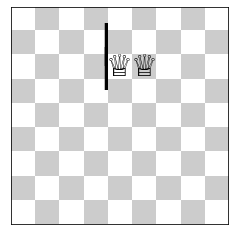

[[4, 1], [3, 1]]
[[3, 1], [4, 1]]
[[4, 2], [3, 2]]
[[3, 2], [4, 2]]
[[2, 1], [4, 1]]
[[2, 2], [4, 2]]
[[5, 1], [3, 1]]
[[5, 2], [3, 2]]
[[3, 1], [4, 2]]
[[4, 2], [3, 1]]
[[3, 2], [4, 1]]
[[4, 1], [3, 2]]


In [13]:
b=board()
b.add_pawn("p1", pawn(5,2))
b.add_pawn("p2", pawn(4,2))
#print(b.pawnController.detect_near("p1"))
#b.add_wall("w1", wall(5, 2, "left"))
b.add_wall("w2", wall(4, 3, "up"))
b.move_pawn("p1", "left")
drawBoard(b.pawnController.matrix(), b.wallController.matrix())
for i in b.wallController.ill_moves():
    print(i)
#print(b.wallController.wallList["w2"].x)